# Discrete Simulation Final Project
Authors: [Felipe Melo](https://github.com/FelipOliveira), [João Canavarro](https://github.com/jvcanavarro) and [Vitor Cantão](https://github.com/VitorCantao).

***
## Metro Bike [Dataset](https://bikeshare.metro.net/about/data/)
*The Metro Bike Share system makes bikes available 24/7, 365 days a year in Downtown LA, Central LA, and North Hollywood (...). Metro Bike Share offers convenient round-the-clock access to a fleet of bicycles for short trips. Metro Bike Share is one of LA Metro's multiple public transportation options for Angelenos and visitors to get around.*

In [2]:
import matplotlib.pyplot as plt
import geopy.distance as gd
import pandas as pd
import numpy as np

### Dataset Overview

In [36]:
df = pd.read_csv('../metrobike-2020.csv')
df.head()

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,134867493,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,30,One Way,Monthly Pass,electric
1,134867799,35,1/1/2020 0:24,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,1,One Way,One Day Pass,smart
2,134868104,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,1,One Way,Walk-up,smart
3,134868103,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,1,One Way,Walk-up,smart
4,134868102,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,1,One Way,Walk-up,smart


In [4]:
# Number of rides in 2020
df.shape[0]

209974

In [5]:
df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type'],
      dtype='object')

In [7]:
# Remove unecessary columns
columns = ['duration', 'start_time', 'end_time', 'start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category', 'bike_type']
df = df[columns]
df.head()

,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,bike_type
0,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,One Way,electric
1,35,1/1/2020 0:24,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,One Way,smart
2,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,One Way,smart
3,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,One Way,smart
4,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,One Way,smart


####  According to Stations [Dataset](https://bikeshare.metro.net/wp-content/uploads/2021/01/metro-bike-share-stations-2021-01-01.csv):
* `4285,Metro Bike Share Free Bikes,2/27/2019,Free Bikes,Active`
* `4286,Metro Bike Share Out of Service Area Smart Bike,2/27/2019,Free Bikes,Active`
* `3000,Virtual Station,7/7/2016,N/A,Active`

Those stations doesn't possess geolocation information, which leads us to ignore then when calculating rides distances

In [16]:
df_null = df[df.isnull().any(axis=1)]
nan_stations = df_null.start_station[df_null['start_lat'].isnull()].unique()
nan_stations

array([4285, 4286, 3000])

In [40]:
# Remove stations without geolocation
df = df.dropna()

In [41]:
# Remove trips starting and ending at the same station
df = df.loc[df.trip_route_category == 'One Way']
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,134867493,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,30,One Way,Monthly Pass,electric
2,134868104,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,1,One Way,Walk-up,smart
3,134868103,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,1,One Way,Walk-up,smart
4,134868102,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,1,One Way,Walk-up,smart
5,134867697,18,1/1/2020 0:35,1/1/2020 0:53,4472,34.092602,-118.280930,4306,34.057652,-118.292183,18937,1,One Way,One Day Pass,electric


In [11]:
# Total bikes within all stations and Nº of stations
print('Number of bicycles: ', len(df['bike_id'].unique()))
print('Number of stations: ', df['start_station'].unique().shape[0])

Number of bicycles:  3998
Number of stations:  266


In [12]:
# Percentage of rides by each model of bicycle
df['bike_type'].value_counts(normalize=True)

standard    0.480782
electric    0.414881
smart       0.104337
Name: bike_type, dtype: float64

In [15]:
# Mean duration of a bike travel
df['duration'].mean()

33.69146876805508

### Calculate distance using geolocation coordenates

In [13]:
def get_distance(coords):
    return gd.geodesic((coords[0], coords[1]), (coords[2], coords[3])).km

In [19]:
# Create new distance column
columns = ['start_lat', 'start_lon', 'end_lat', 'end_lon']
df['distance'] = df.apply(lambda x: get_distance(x[columns]), axis=1)

In [20]:
df.head()

,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,bike_type,distance
0,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,One Way,electric,0.539441
2,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,One Way,smart,5.819566
3,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,One Way,smart,5.819566
4,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,One Way,smart,5.819566
5,18,1/1/2020 0:35,1/1/2020 0:53,4472,34.092602,-118.280930,4306,34.057652,-118.292183,18937,One Way,electric,4.013519


A better option was to filter unique pairs of start and end stations, then calculate the distances. It may be implemented in the future.

In [34]:
df[['duration', 'distance']].describe()

,duration,distance
count,130150.000000,130150.000000
mean,25.987537,3.501088
std,85.131912,138.625385
min,1.000000,0.106798
25%,7.000000,0.703135
50%,12.000000,1.145119
75%,22.000000,1.991158
max,1440.000000,9812.232301


The duration and distance values of rides are very discrepant (see the standard deviation). Eventually, there are cases where people stay with the bike an entire day and then return then to a station, which doesn't reflect the real time they spending at the ride.
In this sense, we decided to ignore those cases when calculating the mean speed of each bycicle model.

### Calculate the average speed of each bicycle model with different intervals of time and space


In [24]:
# Select only necessary columns
time_space = df.iloc[:, [0, 11, 12]]
time_space.head()

,duration,bike_type,distance
0,25,electric,0.539441
2,37,smart,5.819566
3,36,smart,5.819566
4,35,smart,5.819566
5,18,electric,4.013519


In [26]:
def get_speed(space, time, unit):

    if unit == 'km/min': return space / time
    if unit == 'km/h'  : return space / (time / 60)
    if unit == 'm/s'   : return (space * 1000) / (time * 60)

In [27]:
unit = 'km/min'
intervals = [(15, 3), (30, 6), (45, 9), (120, 12)]

avg_speed = pd.DataFrame()
for x, y in enumerate(intervals):
    # Loc the intervals of duration and distance in order to calculate the speed of each model at these situations
    if x == 0:
        time_space_filtered = time_space.loc[(df.duration > 0) & (df.duration <= y[0]) 
                                           & (df.distance > 0) & (df.distance <= y[1])]
    else:
        time_space_filtered = time_space.loc[(df.duration > intervals[x-1][0]) & (df.duration <= y[0]) 
                                           & (df.distance > intervals[x-1][1]) & (df.distance <= y[1])]

    time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
    bike_speed = time_space_filtered.groupby('bike_type').mean()
    avg_speed[y] = bike_speed['speed']

avg_speed

<ipython-input-27-df8ae2edfc06>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
<ipython-input-27-df8ae2edfc06>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
<ipython-input-27-df8ae2edfc06>:14: SettingWithCopyWarning: 
A value is trying to be set on a 

,"(15, 3)","(30, 6)","(45, 9)","(120, 12)"
bike_type,,,,
electric,0.150663,0.189687,0.195431,0.172981
smart,0.154922,0.170135,0.184358,0.114980
standard,0.145599,0.175797,0.185172,0.154657


We are only considering trips with duration and distance up to 120 minutes and 12 kilometers, respectively.

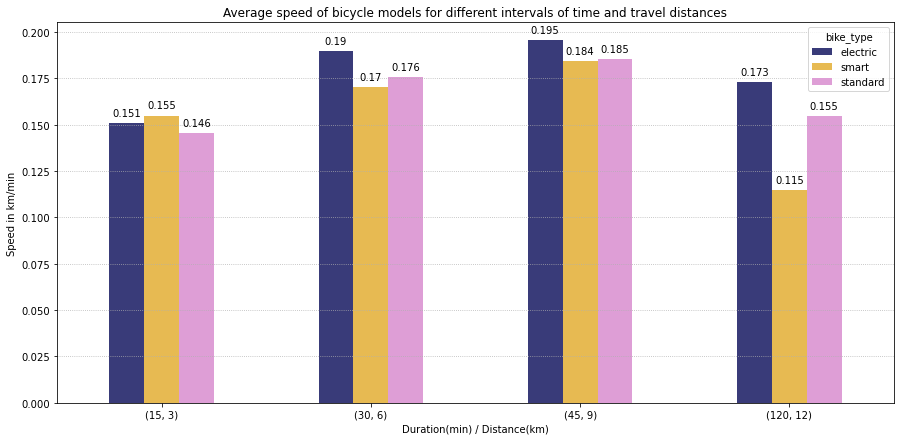

In [28]:
title = 'Average speed of bicycle models for different intervals of time and travel distances'
xlabel = 'Duration(min) / Distance(km)'

ax = avg_speed.T.plot(kind='bar', figsize=(15, 7), xlabel=xlabel, ylabel='Speed in ' + unit, colormap='tab20b', rot=0, title=title)
for p in ax.patches:                 
    ax.annotate(round(p.get_height(),3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.grid(linestyle=':', axis='y')

it is noticeable that electric bicycles have a certain "advantage" over ordinary ones as the distance and duration of the rides increases

#### Normalize the frequency of rides for each unique pair of (start|end) station

In [29]:
# Ignore rides that end at same station and calculate total ocurrences by each ride
group = ['start_station', 'end_station', 'distance']
stations = df.groupby(group).size().reset_index(name='occurs')

# Normalize weights by each group (i.e. each start_station)
stations['norm_rides'] = stations['occurs'] / stations.groupby('start_station')['occurs'].transform('sum')
stations = stations.drop_duplicates(['start_station', 'end_station'])

#### Create frequency and distance matrices

In [32]:
# Pivot to create rides frequency matrix
freq_matrix = stations.pivot(index='start_station', columns='end_station', values='norm_rides').fillna(0)
freq_matrix.head()

end_station,3005,3006,3007,3008,3010,3011,3014,3016,3018,3019,...,4568,4569,4570,4571,4572,4573,4577,4580,4582,4583
start_station,,,,,,,,,,,,,,,,,,,,,
3005,0.000000,0.048855,0.012598,0.019051,0.004916,0.010908,0.006606,0.000154,0.017821,0.014902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,0.112666,0.000000,0.021170,0.024758,0.002512,0.003229,0.011482,0.001076,0.019017,0.020811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,0.079093,0.041692,0.000000,0.005518,0.000000,0.009197,0.007971,0.001226,0.025138,0.012876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3008,0.086839,0.034520,0.005933,0.000000,0.001618,0.019957,0.004315,0.000000,0.008630,0.008091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,0.087542,0.070707,0.003367,0.050505,0.000000,0.000000,0.023569,0.003367,0.016835,0.016835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Stations distance matrix
distance_matrix = stations.pivot(index='start_station', columns='end_station', values='distance').fillna(0)
distance_matrix.head()

end_station,3005,3006,3007,3008,3010,3011,3014,3016,3018,3019,...,4568,4569,4570,4571,4572,4573,4577,4580,4582,4583
start_station,,,,,,,,,,,,,,,,,,,,,
3005,0.000000,0.370922,0.425258,0.440409,1.314694,1.195366,2.164585,1.641468,0.549178,1.117860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,0.370922,0.000000,0.580489,0.572496,0.956511,1.153563,2.175862,1.616011,0.378074,0.860632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,0.425258,0.580489,0.000000,0.865427,0.000000,1.613698,1.742760,1.232670,0.906916,1.438201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3008,0.440409,0.572496,0.865427,0.000000,1.285645,0.777609,2.604177,0.000000,0.399279,0.904462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,1.314694,0.956511,1.490136,1.285645,0.000000,0.000000,2.714000,2.144889,0.886902,0.579519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
#### Simulation
* 575 rides/day

Create Stations

In [33]:
import simpy
import random

STATIONS = freq_matrix.index
BIKE_TYPE = df['bike_type'].unique()

NUMBER_OF_RIDES = 575
NUMBER_OF_BIKES = 3983
NUMBER_OF_STATIONS = 263
NUMBER_OF_BIKES_PER_STATION = NUMBER_OF_BIKES // NUMBER_OF_STATIONS
INTERVALS = intervals


class Station(object):
    def __init__(self, env, station_id):
        self.env = env
        self.id = station_id
        self.capacity = NUMBER_OF_BIKES_PER_STATION * 2

        
def get_station(stations):
    station_id = random.choice(STATIONS)
    # select the first object from the list that has same id
    station = next((x for x in stations if x.id == station_id))
    return station

def get_duration(start_station, end_station, bike_type):
    distance = distance_matrix[start_station.id][end_station.id]
    
    for index, item in enumerate(intervals):
        print(y[1])
        if index == 0:
            if 0 < distance <= item[1]:
                # Distance is between 0 and interval[0](15km)
                pass
        else:
            if intervals[index-1][1] < distance <= item[1]:
                # Distance is between interval[-1] and interval (15-30km)
                pass
            
        # OBS: acessing avg_speed['bike_type'][interval] isn't working for some reason
        # I managed to 'fix' it by acessing avg_speed.T[interval]['bike_type']
        # (using df.T -> transpose matrix)
        
    # After getting the bike speed by bike_type~interval, it's just necessary to return
    # distance / speed 

def ride(env, start_station, end_station, bike_type):
    duration = get_duration(start_station, end_station, bike_type)
    

def cyclist_arrivals(env, stations):
    while True:
        yield env.timeout(random.expovariate(1 / 0.5))
        distance = 0
        while distance == 0:
            start_station = get_station(stations)
            end_station = get_station(stations)
            distance = distance_matrix[start_station.id][end_station.id]
        bike_type = random.choice(BIKE_TYPE)
        
        # Pick a bike of choosen model from start_station and 'send' to end_station
        ride(env, start_station, end_station, bike_type)
        
def setup(env):
    stations = []
    for station_id in STATIONS:
        stations.append(Station(env, station_id))
    while True:
        yield env.timeout(random.randint(3 - 2, 3 + 2))
        env.process(cyclist_arrivals(env, stations))
    
    
env = simpy.Environment()
env.process(setup(env))
env.run(until=10)

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
